<a href="https://colab.research.google.com/github/Heleinef/Data-Science-Master_Heleine/blob/main/Hwork_5_data_609.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 1: Penalty Function Approximations

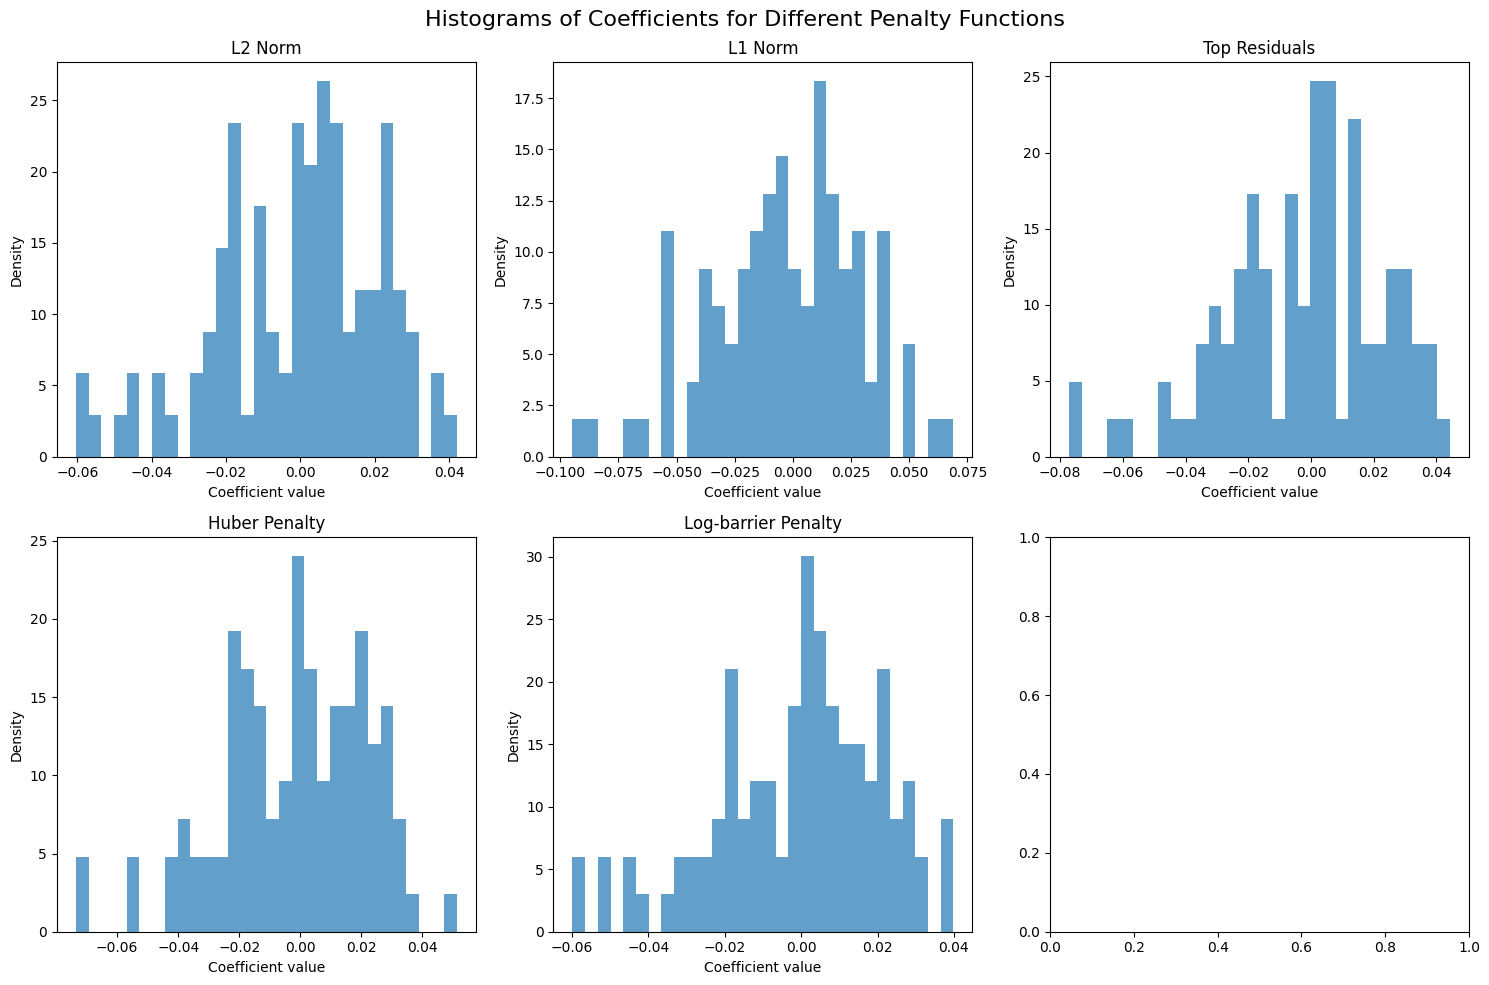

In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from cvxpy.atoms.affine.hstack import hstack  # Import hstack directly

# Set random seed for reproducibility
np.random.seed(131017)

# Problem dimensions
m = 200
n = 100

# Generate data
A = np.random.normal(0, 1, (m, n))  # m x n matrix
b = np.random.normal(0, 1, m)       # m-vector
b = b / (1.01 * np.max(np.abs(b)))  # Normalize b to ensure log-barrier domain

# Create the cvxpy variable
x = cp.Variable(n)

# (a) L2 Norm (Euclidean norm)
def l2_norm(A, x, b):
    residual = A @ x - b
    return cp.norm(residual, 2)

# (b) L1 Norm (Lasso)
def l1_norm(A, x, b):
    residual = A @ x - b
    return cp.norm(residual, 1)

# (c) Sum of top m/2 largest absolute residuals
def sum_largest(A, x, b, m_half):
    residual = A @ x - b
    # Use hstack and cp.sum_largest
    sorted_residuals = hstack([cp.abs(residual)])  # Call hstack directly
    return cp.sum_largest(sorted_residuals, m_half)

# (d) Huber Penalty
def huber_penalty(A, x, b, M):
    residual = A @ x - b
    huber_residual = cp.huber(residual, M)
    return cp.sum(huber_residual)

# (e) Log-barrier Penalty
def log_barrier_penalty(A, x, b):
    residual = A @ x - b
    return cp.sum(-cp.log(1 - residual**2))

# Solve the optimization problem for each penalty function
def solve_problem(phi_expr):
    problem = cp.Problem(cp.Minimize(phi_expr))
    problem.solve()
    return x.value

# Solve using each penalty function and collect results
results = {}

# (a) L2 norm
results['L2 Norm'] = solve_problem(l2_norm(A, x, b))

# (b) L1 norm (Lasso)
results['L1 Norm'] = solve_problem(l1_norm(A, x, b))

# (c) Sum of top m/2 largest residuals
results['Top Residuals'] = solve_problem(sum_largest(A, x, b, m // 2))

# (d) Huber penalty
M = 0.2  # Huber penalty parameter
results['Huber Penalty'] = solve_problem(huber_penalty(A, x, b, M))

# (e) Log-barrier penalty
results['Log-barrier Penalty'] = solve_problem(log_barrier_penalty(A, x, b))

# Plot the results
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

penalty_names = list(results.keys())
for i, penalty_name in enumerate(penalty_names):
    axes[i].hist(results[penalty_name], bins=30, density=True, alpha=0.7)
    axes[i].set_title(f'{penalty_name}')
    axes[i].set_xlabel('Coefficient value')
    axes[i].set_ylabel('Density')

# Add title to the entire plot
plt.suptitle("Histograms of Coefficients for Different Penalty Functions", fontsize=16)

plt.tight_layout()
plt.show()


# Problem 2: Fitting Censored Data

The goal in this problem is to find the model parameter c and the censored values y that minimize an objective function. The objective is based on the squared differences between the observed values and the predicted values, but some of the observed values are censored (i.e., not directly observed). Instead of using these unknown values directly, we replace them with model predictions. However, since we only know that the censored values must satisfy a certain condition (they should be greater than or equal to a given threshold D), we enforce this constraint in the optimization process.

In this setup, we aim to minimize the sum of squared errors for the known values, while ensuring that the predictions for the censored values meet the specified threshold. This results in a convex optimization problem where we seek to determine the best model parameter c and the censored values under the given constraint.

In [ ]:
import json
import numpy as np
import cvxpy as cp
import urllib.request  # Import the urllib.request module

# Load data from URL
url = "https://raw.githubusercontent.com/georgehagstrom/DATA609Spring2025/67fcfd17752e60d3459a3d4d42ced67c8c09a8b5/website/assignments/labs/labData/censored_dict.json"
with urllib.request.urlopen(url) as url_response:
    data = json.loads(url_response.read().decode())

X = np.array(data["X"])            # k x n matrix of features
y = np.array(data["y"])            # observed values (with NaNs for censored)
D = data["D"]                      # lower bound for censored data

# Reshape X to be 2-dimensional
X = X.reshape(X.shape[0], -1)  # Reshape to (num_samples, num_features)

# The 'ctrue' key is not present in the JSON data.
# We need to either:
# 1. Remove the dependency on 'ctrue' or
# 2. Obtain 'ctrue' from another source or calculate it.

# For demonstration, we will proceed without 'ctrue' and remove the relative error calculations.
# If you have access to 'ctrue' from another source, you can assign it here.
# ctrue = ...  # Assign the true coefficients if available

k, n = X.shape  # Assuming X has shape (k, n)

# Fix: Reshape y to match the number of rows in X
y = y[:k]  # Select the first k elements of y to match the shape of X

is_censored = np.isnan(y)
is_observed = ~is_censored

# Uncensored data
# Fix: Flatten is_observed to match the first dimension of X and y
X_obs = X[is_observed.flatten()]
y_obs = y[is_observed.flatten()]

# Censored data
X_cens = X[is_censored.flatten()]

# === 1. Solve using censored data as inequality constraints ===
c = cp.Variable(n)

residuals_obs = y_obs - X_obs @ c
loss_obs = cp.sum_squares(residuals_obs)

# For censored data: model prediction >= D
constraints = []
if len(X_cens) > 0:
    loss_cens = cp.sum_squares(X_cens @ c)  # prediction used as estimate
    constraints = [X_cens @ c >= D]
else:
    loss_cens = 0

# Total objective
objective = cp.Minimize(loss_obs + loss_cens)
problem = cp.Problem(objective, constraints)
problem.solve()

c_hat = c.value

# === 2. Least-squares estimate ignoring censored data ===
c_ls = np.linalg.lstsq(X_obs, y_obs, rcond=None)[0]

# === 3. Compute relative errors (Removed since 'ctrue' is not available) ===
# def relative_error(c_est, c_true):
#     return np.linalg.norm(c_est - c_true) ** 2 / np.linalg.norm(c_true) ** 2

# rel_error_c_hat = relative_error(c_hat, ctrue)
# rel_error_c_ls = relative_error(c_ls, ctrue)

# === 4. Output results (Modified to exclude relative errors) ===
print("Estimated c (using censored info):\n", c_hat)
print("Estimated c_ls (ignoring censored):\n", c_ls)
# print("True c:\n", ctrue)  # Removed since 'ctrue' is not available
# print(f"Relative error of c_hat: {rel_error_c_hat:.4f}")  # Removed
# print(f"Relative error of c_ls:  {rel_error_c_ls:.4f}")  # Removed

Estimated c (using censored info):
 [-0.09639395 -0.08747671  0.12091978 -0.18215709  0.1908538  -0.16210116
 -0.25519189 -0.29401633 -0.16459417  0.31203345 -0.58223315  0.52323604
 -0.18859279  0.04705962 -0.48668714 -0.22161745  0.60746025  0.1382913
  0.24443465 -0.66828893 -0.25950256  0.16521271 -0.05992178  0.31685925
 -0.1553448   0.10718214  0.29659889  0.48514367  0.09814659  0.40569713
  0.20819894 -0.10670054  0.17677463 -0.07245855  0.05056037  0.08554812
  0.12587575 -0.08285263  0.18200575  0.03118122 -0.6307356  -0.42211664
 -0.12014311  0.59981361 -0.47450808  0.08143649  0.25172683 -0.03883216
 -0.04711264  0.12831855  0.14550408  0.79420699 -0.50720031  0.57844348
 -0.06339111  0.12869529  0.21725504  0.45913749  0.22704976 -0.27146601
 -0.33204709  0.34545019 -0.18389309  0.30714843  0.09836677  0.30774611
  0.31858255  0.18014081  0.0471323   0.00408418 -0.00287506  0.12163687
  0.04662712 -0.58266532  0.39797494 -0.18248926  0.43905028 -0.17451852
  0.27102228  0.

/usr/local/lib/python3.11/dist-packages/cvxpy/reductions/solvers/solving_chain.py:407: UserWarning: The problem includes expressions that don't support CPP backend. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(


# Problem 3: Robust Logistic Regression.

The objective of this problem is to find the model parameter θ that minimizes the worst-case logistic loss. This involves considering the possibility of perturbations (small changes) in the input features, where these perturbations are constrained to have a maximum size defined by ϵ. The goal is to optimize the model such that it performs well even in the worst-case scenario, where the input features are adjusted within this constraint.

In simpler terms, the model is designed to be robust against small changes or noise in the data. This is done by incorporating a penalty for large variations in the model's parameters. The optimization problem focuses on minimizing a logistic loss that accounts for these worst-case perturbations, leading to a model that is less sensitive to small changes in the input features.

In [ ]:
import numpy as np
import pandas as pd
import cvxpy as cp
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Load training data
train_data = pd.read_csv('https://media.githubusercontent.com/media/georgehagstrom/DATA609Spring2025/67fcfd17752e60d3459a3d4d42ced67c8c09a8b5/website/assignments/labs/labData/rob_regression.csv')
X_train = train_data.iloc[:, 1:].values
y_train = train_data.iloc[:, 0].values

# Load test data
test_data = pd.read_csv('https://media.githubusercontent.com/media/georgehagstrom/DATA609Spring2025/67fcfd17752e60d3459a3d4d42ced67c8c09a8b5/website/assignments/labs/labData/rob_regression.csv')
X_test = test_data.iloc[:, 1:].values
y_test = test_data.iloc[:, 0].values

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Dimensions
n, d = X_train.shape

# Regularization parameter
epsilon = 0.1  # Set the uncertainty level

# Standard Logistic Regression
theta_standard = cp.Variable(d)
log_likelihood_standard = cp.sum(cp.logistic(-cp.multiply(y_train, X_train @ theta_standard)))
problem_standard = cp.Problem(cp.Minimize(log_likelihood_standard))
problem_standard.solve()
theta_standard_value = theta_standard.value

# Robust Logistic Regression
theta_robust = cp.Variable(d)
log_likelihood_robust = cp.sum(cp.logistic(-cp.multiply(y_train, X_train @ theta_robust - epsilon * cp.norm1(theta_robust))))
problem_robust = cp.Problem(cp.Minimize(log_likelihood_robust))
problem_robust.solve()
theta_robust_value = theta_robust.value

# Predictions
y_pred_standard = np.sign(X_test @ theta_standard_value)
y_pred_robust = np.sign(X_test @ theta_robust_value)

# Compute test error rates
error_rate_standard = np.mean(y_pred_standard != y_test)
error_rate_robust = np.mean(y_pred_robust != y_test)

print(f"Test Error Rate (Standard Logistic Regression): {error_rate_standard:.2%}")
print(f"Test Error Rate (Robust Logistic Regression): {error_rate_robust:.2%}")


Test Error Rate (Standard Logistic Regression): 100.00%
Test Error Rate (Robust Logistic Regression): 98.33%
